In [1]:
%load_ext autoreload
%autoreload 2

import os
# Run everything on CPU, if GPU is available comment out
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("src/")
import src.preprocessing.data_loading as data_loading
import src.preprocessing.SL_Xstreme as SL_Xstreme
import src.analysis.ConstrainedLibFunctions as ConstrainedLib
import models.experiment as experiment
import models.rnn as rnn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import norm
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from tensorflow import keras
from functools import partial
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
    benchmark_cross_validated_hit_rate,
)
from analysis.scatter_plots import (
    plot_fancy_hexbin_relations
)
from models.rnn import multi_channel_mse

Generating ER datafiles!


## Checking Ring Sizes

In [2]:
# To look at ring sizes in phage
file_path = r"/Volumes/Extreme SSD/NGS8/30-1181097629/00_fastq/15m/Keeping2Cysteines.csv" #NGS8
df = pd.read_csv(file_path)
print(df.shape)
df = df.iloc[:, :-2]
df = df.dropna(subset=[df.columns[-1]])
df.head()

(486584, 8)


,GCTCATCAGGTGAATCCGGTTGCGTAGCGGTGTGGGGCGACGGCTTGC,9,AHQVNPVAQRCGATAC,2.59245E-06,0.000274512,4
4,GCTGGTCCGATGTTGATGGTTGAGGGGGGTCCGTTGACGTGTTGGTGC,8,AGPMLMVEGGPLTCWC,0.000002,0.000275,1.0
8,GCTGAGACGATGCATTGGAGTGGGTGTCATAGTATGGATCTGGCGTGC,8,AETMHWSGCHSMDLAC,0.000002,0.000275,6.0
11,GCTGCGACTGGTGTGTGTATTAATGTGGGTCTTAGGCTTACGGGGTGC,8,AATGVCINVGLRLTGC,0.000002,0.000275,9.0
16,GCTGGTGTTCAGGCGAGGGGTCGTTTTCGTTGTCCTTCTAGGCCGTGC,7,AGVQARGRFRCPSRPC,0.000002,0.000275,4.0
17,GCTGCGTGGAATACGTAGCATAAGAGGTTGCCGCGTGTGGAGTGTTGC,7,AAWNTQHKRLPRVECC,0.000002,0.000275,0.0


In [3]:
# Suppose your loop sizes are in this column:
loop_sizes = df[df.columns[-1]]  # or replace with your specific column name

# Get counts for each loop size 0–14
observed = loop_sizes.value_counts().reindex(range(14), fill_value=0).sort_index()

# Expected count per bin (uniform distribution)
expected = [observed.sum() / 14] * 14

# Chi-square test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square: {chi2_stat:.2f}, p-value: {p_val:.4e}")

residuals = (observed - expected) / np.sqrt(expected)
residuals = residuals.round(2)
print(residuals)
# likes loop gaps of 3 or 10
# dislikes loop gaps of 0,6,13

Chi-square: 110.86, p-value: 1.2663e-17
0    -5.07
1     1.45
2     1.61
3     6.53
4    -1.03
5    -0.30
6    -3.79
7    -1.56
8     1.04
9     0.14
10    2.84
11   -0.69
12    1.60
13   -2.77
Name: 4, dtype: float64


In [4]:
# Assuming your loop sizes are in the last column
loop_sizes = df[df.columns[-1]]

# Count observed occurrences per loop size (0–14)
observed = loop_sizes.value_counts().reindex(range(14), fill_value=0).sort_index()

# Total observations and expected under uniform distribution
N = observed.sum()
k = len(observed)
expected = N / k

# Z-scores for each category
z_scores = (observed - expected) / np.sqrt(expected)

# Two-tailed p-values
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Manual Bonferroni correction
alpha = 0.05
bonferroni_corrected_p = np.minimum(p_values * k, 1.0)  # Cap at 1.0

# Significance test
significant = bonferroni_corrected_p < alpha

# Assemble results table
results = pd.DataFrame({
    'Loop Size': range(14),
    'Observed': observed,
    'Expected': [expected] * 14,
    'Z-score': z_scores.round(2),
    'Raw P-value': p_values,
    'Bonferroni-corrected P-value': bonferroni_corrected_p,
    'Significant': significant
})

print(results)
# 0,3,and 6 loop sizes are statistically significant via bonferonni z-test

    Loop Size  Observed      Expected  Z-score   Raw P-value  \
0           0     10473  11005.071429    -5.07  3.937951e-07   
1           1     11157  11005.071429     1.45  1.475476e-01   
2           2     11174  11005.071429     1.61  1.073325e-01   
3           3     11690  11005.071429     6.53  6.619572e-11   
4           4     10897  11005.071429    -1.03  3.029240e-01   
5           5     10974  11005.071429    -0.30  7.670879e-01   
6           6     10608  11005.071429    -3.79  1.536745e-04   
7           7     10841  11005.071429    -1.56  1.178178e-01   
8           8     11114  11005.071429     1.04  2.991053e-01   
9           9     11020  11005.071429     0.14  8.868387e-01   
10         10     11303  11005.071429     2.84  4.511596e-03   
11         11     10933  11005.071429    -0.69  4.920728e-01   
12         12     11173  11005.071429     1.60  1.094285e-01   
13         13     10714  11005.071429    -2.77  5.526664e-03   

    Bonferroni-corrected P-value  Signi

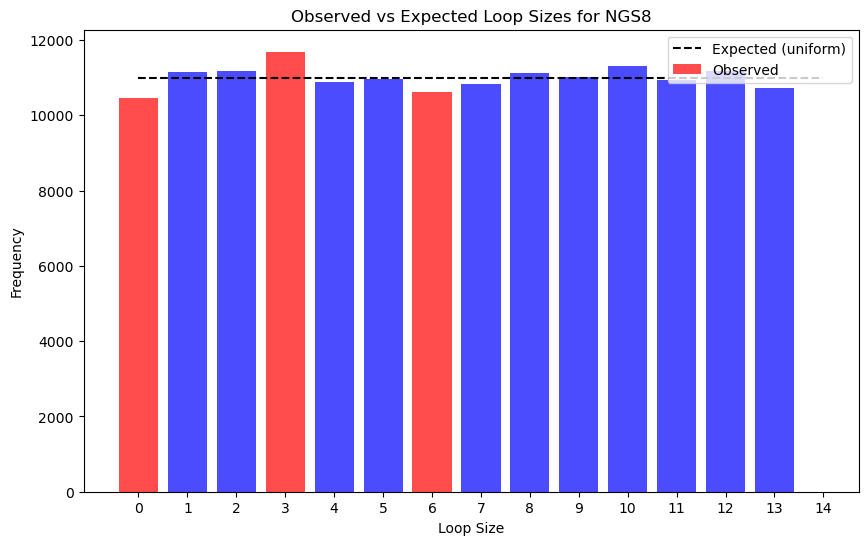

In [5]:
# Define which loop sizes are significant
significant_bins = [0, 3, 6]

# Assign colors: red for significant, blue for others
bar_colors = ['red' if i in significant_bins else 'blue' for i in observed.index]

plt.figure(figsize=(10, 6))
plt.bar(observed.index, observed.values, color=bar_colors, alpha=0.7, label="Observed")
plt.hlines(expected, 0, 14, colors='black', linestyles='dashed', label="Expected (uniform)")
plt.xlabel("Loop Size")
plt.ylabel("Frequency")
plt.title("Observed vs Expected Loop Sizes for NGS8")
plt.xticks(range(15))
plt.legend()
plt.show()

In [7]:
# To look at ring sizes in phage

file_path = r"/Volumes/Extreme SSD/NGS8/30-1181097629/00_fastq/15m/6cwhole_R1_001_10m.csv" #NGS8
df2 = pd.read_csv(file_path)
print(df.shape)
df2 = df2.dropna(subset=[df2.columns[-1]])
df2.head()

(154071, 6)


,GCTTTGTATCAGTTGGAGAATGGTGTTTTGGGTGGTCAGGTGTGTTGC,9,ALYQLENGVLGGQVCC,3.89E-06,0.000278439,0
4,GCTGGGATTCGGTGGGGTAGGGCGTGGAGGTGTACGTATCTGGTGTGC,8,AGIRWGRAWRCTYLVC,0.000003,0.000278,4.0
5,GCTAGTTCTGGGGGGAGGATGCGTGAGGCGTGTCGGGATTCTGGTTGC,8,ASSGGRMREACRDSGC,0.000003,0.000278,4.0
6,GCTTGGTAGGAGTGGTAGGAGACTGGTAAGCATTTGGTGGATTGTTGC,8,AWQEWQETGKHLVDCC,0.000003,0.000278,0.0
8,GCTCTTAATGTGGGTTTGGTGCGGGCGCTGAAGTGTAGTGAGGGTTGC,8,ALNVGLVRALKCSEGC,0.000003,0.000278,3.0
10,GCTCTGTGTGCTCTGCCTCATGTTACGCGGAGTGGTTCGTAGGATTGC,7,ALCALPHVTRSGSQDC,0.000003,0.000278,12.0


In [8]:
# Suppose your loop sizes are in this column:
loop_sizes = df2[df2.columns[-1]]  # or replace with your specific column name

# Get counts for each loop size 0–14
observed = loop_sizes.value_counts().reindex(range(14), fill_value=0).sort_index()

# Expected count per bin (uniform distribution)
expected = [observed.sum() / 14] * 14

# Chi-square test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square: {chi2_stat:.2f}, p-value: {p_val:.4e}")

Chi-square: 89.39, p-value: 1.8306e-13


In [9]:
residuals = (observed - expected) / np.sqrt(expected)
residuals = residuals.round(2)
print(residuals)
# likes loop gaps of 3 or 10
# dislikes loop gaps of 0,6,13

0    -3.43
1     1.40
2     0.78
3     6.10
4    -1.97
5     0.29
6    -4.37
7    -1.69
8     0.35
9     0.94
10    2.19
11   -0.67
12    1.73
13   -1.65
Name: 0, dtype: float64


In [10]:
# Assuming your loop sizes are in the last column
loop_sizes = df2[df2.columns[-1]]

# Count observed occurrences per loop size (0–14)
observed = loop_sizes.value_counts().reindex(range(14), fill_value=0).sort_index()

# Total observations and expected under uniform distribution
N = observed.sum()
k = len(observed)
expected = N / k

# Z-scores for each category
z_scores = (observed - expected) / np.sqrt(expected)

# Two-tailed p-values
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Manual Bonferroni correction
alpha = 0.05
bonferroni_corrected_p = np.minimum(p_values * k, 1.0)  # Cap at 1.0

# Significance test
significant = bonferroni_corrected_p < alpha

# Assemble results table
results = pd.DataFrame({
    'Loop Size': range(14),
    'Observed': observed,
    'Expected': [expected] * 14,
    'Z-score': z_scores.round(2),
    'Raw P-value': p_values,
    'Bonferroni-corrected P-value': bonferroni_corrected_p,
    'Significant': significant
})

print(results)
# 0,3,and 6 loop sizes are statistically significant via bonferonni z-test

    Loop Size  Observed     Expected  Z-score   Raw P-value  \
0           0      7471  7773.285714    -3.43  6.067297e-04   
1           1      7897  7773.285714     1.40  1.605592e-01   
2           2      7842  7773.285714     0.78  4.357607e-01   
3           3      8311  7773.285714     6.10  1.068220e-09   
4           4      7600  7773.285714    -1.97  4.936299e-02   
5           5      7799  7773.285714     0.29  7.705490e-01   
6           6      7388  7773.285714    -4.37  1.242514e-05   
7           7      7624  7773.285714    -1.69  9.041171e-02   
8           8      7804  7773.285714     0.35  7.275639e-01   
9           9      7856  7773.285714     0.94  3.481608e-01   
10         10      7966  7773.285714     2.19  2.882981e-02   
11         11      7714  7773.285714    -0.67  5.013093e-01   
12         12      7926  7773.285714     1.73  8.325264e-02   
13         13      7628  7773.285714    -1.65  9.938118e-02   

    Bonferroni-corrected P-value  Significant  
0     

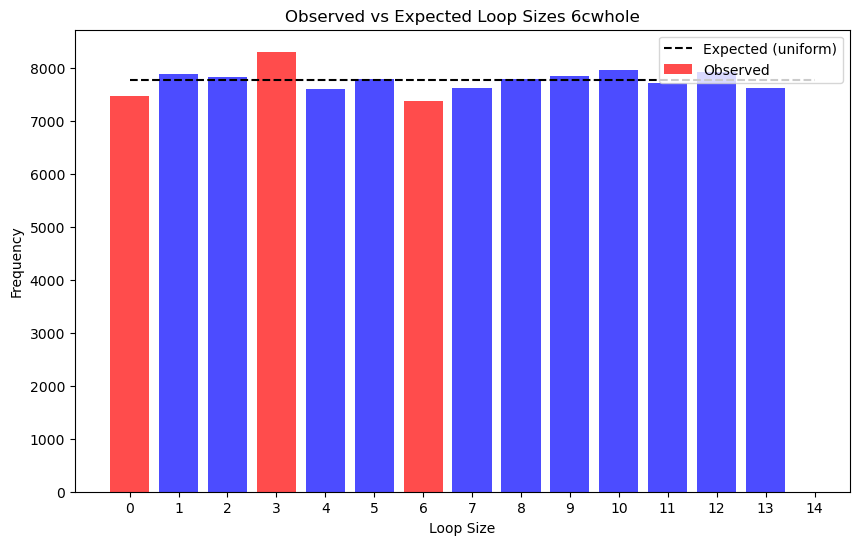

In [11]:
# Define which loop sizes are significant
significant_bins = [0, 3, 6]

# Assign colors: red for significant, blue for others
bar_colors = ['red' if i in significant_bins else 'blue' for i in observed.index]

plt.figure(figsize=(10, 6))
plt.bar(observed.index, observed.values, color=bar_colors, alpha=0.7, label="Observed")
plt.hlines(expected, 0, 14, colors='black', linestyles='dashed', label="Expected (uniform)")
plt.xlabel("Loop Size")
plt.ylabel("Frequency")
plt.title("Observed vs Expected Loop Sizes 6cwhole")
plt.xticks(range(15))
plt.legend()
plt.show()

In [12]:
# To look at ring sizes in phage

file_path = r"/Volumes/Extreme SSD/NGS7/00_fastq/10m/03182025NGS7_R1_001_10m.csv" #NGS8
df3 = pd.read_csv(file_path)
print(df.shape)
df3 = df3.dropna(subset=[df3.columns[-1]])
df3.head()

(154071, 6)


,GCTCTGGGTCGTGCTGGGGAGTTTTGTGAGCTTCAGCGGACTCTGTGC,9,ALGRAGEFCELQRTLC,4.51258E-06,0.000335599,6
4,GCTAGGTCGTGTCCTCTGGCTTGGGATTAGTCTGTTTAGGTGGGGTGC,7,ARSCPLAWDQSVQVGC,0.000004,0.000336,11.0
5,GCTGCTAAGCGGTGGTTTTTGGGGAGGTGTGTTTGGCAGGGGTATTGC,6,AAKRWFLGRCVWQGYC,0.000003,0.000336,5.0
8,GCTCATAGTCAGTAGTGTCTTGCGGCTATGAGGGGGGGGGATGAGTGC,6,AHSQQCLAAMRGGDEC,0.000003,0.000336,9.0
9,GCTTGTGGGTAGATTCTTCTTTATCGGAGGAGGGTTCTGAGTGGGTGC,6,ACGQILLYRRRVLSGC,0.000003,0.000336,13.0
11,GCTCATTTGTCGAGGGCGTGTTATGGGGAGAAGATGGGTGGGTTGTGC,6,AHLSRACYGEKMGGLC,0.000003,0.000336,8.0


In [13]:
# Suppose your loop sizes are in this column:
loop_sizes = df3[df3.columns[-1]]  # or replace with your specific column name

# Get counts for each loop size 0–14
observed = loop_sizes.value_counts().reindex(range(14), fill_value=0).sort_index()

# Expected count per bin (uniform distribution)
expected = [observed.sum() / 14] * 14

# Chi-square test
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square: {chi2_stat:.2f}, p-value: {p_val:.4e}")

residuals = (observed - expected) / np.sqrt(expected)
residuals = residuals.round(2)
print(residuals)
# likes loop gaps of 3
# dislikes loop gaps of 0,4,7

Chi-square: 48.16, p-value: 6.1551e-06
0    -2.25
1     0.92
2     1.51
3     3.72
4    -2.36
5     2.17
6    -1.71
7    -2.19
8    -1.90
9    -0.38
10    1.28
11   -0.78
12    1.28
13    0.71
Name: 6, dtype: float64


In [14]:
# Assuming your loop sizes are in the last column
loop_sizes = df3[df3.columns[-1]]

# Count observed occurrences per loop size (0–14)
observed = loop_sizes.value_counts().reindex(range(14), fill_value=0).sort_index()

# Total observations and expected under uniform distribution
N = observed.sum()
k = len(observed)
expected = N / k

# Z-scores for each category
z_scores = (observed - expected) / np.sqrt(expected)

# Two-tailed p-values
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Manual Bonferroni correction
alpha = 0.05
bonferroni_corrected_p = np.minimum(p_values * k, 1.0)  # Cap at 1.0

# Significance test
significant = bonferroni_corrected_p < alpha

# Assemble results table
results = pd.DataFrame({
    'Loop Size': range(14),
    'Observed': observed,
    'Expected': [expected] * 14,
    'Z-score': z_scores.round(2),
    'Raw P-value': p_values,
    'Bonferroni-corrected P-value': bonferroni_corrected_p,
    'Significant': significant
})

print(results)
# 0,3,and 6 loop sizes are statistically significant via bonferonni z-test

    Loop Size  Observed     Expected  Z-score  Raw P-value  \
0           0      2636  2753.928571    -2.25     0.024627   
1           1      2802  2753.928571     0.92     0.359650   
2           2      2833  2753.928571     1.51     0.131873   
3           3      2949  2753.928571     3.72     0.000201   
4           4      2630  2753.928571    -2.36     0.018199   
5           5      2868  2753.928571     2.17     0.029727   
6           6      2664  2753.928571    -1.71     0.086594   
7           7      2639  2753.928571    -2.19     0.028521   
8           8      2654  2753.928571    -1.90     0.056884   
9           9      2734  2753.928571    -0.38     0.704130   
10         10      2821  2753.928571     1.28     0.201218   
11         11      2713  2753.928571    -0.78     0.435438   
12         12      2821  2753.928571     1.28     0.201218   
13         13      2791  2753.928571     0.71     0.479927   

    Bonferroni-corrected P-value  Significant  
0                    

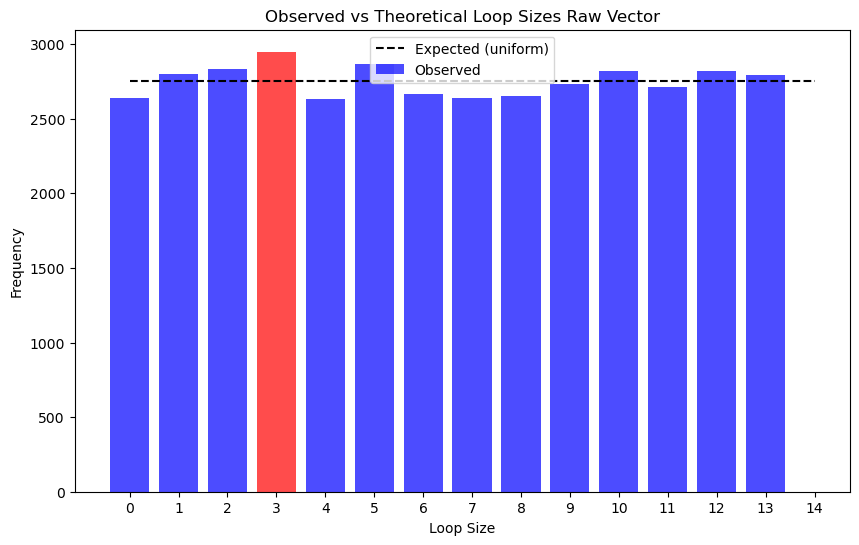

In [15]:
# Define which loop sizes are significant
significant_bins = [3]

# Assign colors: red for significant, blue for others
bar_colors = ['red' if i in significant_bins else 'blue' for i in observed.index]

plt.figure(figsize=(10, 6))
plt.bar(observed.index, observed.values, color=bar_colors, alpha=0.7, label="Observed")
plt.hlines(expected, 0, 14, colors='black', linestyles='dashed', label="Expected (uniform)")
plt.xlabel("Loop Size")
plt.ylabel("Frequency")
plt.title("Observed vs Theoretical Loop Sizes Raw Vector")
plt.xticks(range(15))
plt.legend()
plt.show()

In [16]:
from scipy.stats import chi2_contingency

# Get loop sizes (assumed in last column)
observed_loop_sizes = df2[df2.columns[-1]]
expected_loop_sizes = df3[df3.columns[-1]]

# Define loop size range (adjust if needed)
loop_size_range = range(14)

# Count occurrences of each loop size in each sample
observed_counts = observed_loop_sizes.value_counts().reindex(loop_size_range, fill_value=0).sort_index()
expected_counts = expected_loop_sizes.value_counts().reindex(loop_size_range, fill_value=0).sort_index()

# Build contingency table
contingency_table = pd.DataFrame({
    'Sample1': observed_counts,
    'Sample2': expected_counts
}).T  # Transpose so rows = samples, columns = loop sizes

# Run Chi-square test
chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print("Chi-square test results:")
print(f"Chi2 statistic = {chi2:.2f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p_value:.4f}")

# Optional: print contingency table and expected frequencies
print("\nObserved counts:")
print(contingency_table)
print("\nExpected frequencies under null:")
print(pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns))

Chi-square test results:
Chi2 statistic = 12.73
Degrees of freedom = 13
P-value = 0.4687

Observed counts:
           0     1     2     3     4     5     6     7     8     9     10  \
Sample1  7471  7897  7842  8311  7600  7799  7388  7624  7804  7856  7966   
Sample2  2636  2802  2833  2949  2630  2868  2664  2639  2654  2734  2821   

           11    12    13  
Sample1  7714  7926  7628  
Sample2  2713  2821  2791  

Expected frequencies under null:
                  0            1            2            3            4   \
Sample1  7462.999858  7900.132134  7882.410555  8314.374037  7553.822949   
Sample2  2644.000142  2798.867866  2792.589445  2945.625963  2676.177051   

                  5            6            7            8           9   \
Sample1  7876.503362  7422.387906  7578.190119  7722.177947  7819.64663   
Sample2  2790.496638  2629.612094  2684.809881  2735.822053  2770.35337   

                  10           11           12           13  
Sample1  7965.111256  7699

In [18]:
# Compute standardized residuals: (O - E) / sqrt(E)
z_scores = (contingency_table - expected_freq) / np.sqrt(expected_freq)
z_scores = pd.DataFrame(z_scores, index=contingency_table.index, columns=contingency_table.columns)

# Two-tailed raw p-values
raw_p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))
raw_p_values = pd.DataFrame(raw_p_values, index=contingency_table.index, columns=contingency_table.columns)

# Bonferroni correction
n_tests = z_scores.size
bonferroni_p_values = np.minimum(raw_p_values * n_tests, 1.0)
bonferroni_p_values = pd.DataFrame(bonferroni_p_values, index=contingency_table.index, columns=contingency_table.columns)

# Significant flags
significant = bonferroni_p_values < 0.05

# Assemble results
detailed_results = pd.DataFrame({
    "Loop Size": loop_size_range,
    "Observed_Sample1": contingency_table.loc["Sample1"].values,
    "Observed_Sample2": contingency_table.loc["Sample2"].values,
    "Z-score_Sample1": z_scores.loc["Sample1"].round(2),
    "Z-score_Sample2": z_scores.loc["Sample2"].round(2),
    "P-value_Sample1": raw_p_values.loc["Sample1"],
    "P-value_Sample2": raw_p_values.loc["Sample2"],
    "Bonferroni_Sample1": bonferroni_p_values.loc["Sample1"],
    "Bonferroni_Sample2": bonferroni_p_values.loc["Sample2"],
    "Significant_Sample1": significant.loc["Sample1"],
    "Significant_Sample2": significant.loc["Sample2"]
})

# Display results
print("\nPer-loop-size statistical test results:")
print(detailed_results)


Per-loop-size statistical test results:
    Loop Size  Observed_Sample1  Observed_Sample2  Z-score_Sample1  \
0           0              7471              2636             0.09   
1           1              7897              2802            -0.04   
2           2              7842              2833            -0.46   
3           3              8311              2949            -0.04   
4           4              7600              2630             0.53   
5           5              7799              2868            -0.87   
6           6              7388              2664            -0.40   
7           7              7624              2639             0.53   
8           8              7804              2654             0.93   
9           9              7856              2734             0.41   
10         10              7966              2821             0.01   
11         11              7714              2713             0.17   
12         12              7926              2821

## Check Amino Acid Composition

In [19]:
from collections import Counter

# Load the CSV
file_path = r"/Volumes/Extreme SSD/NGS8/30-1181097629/00_fastq/15m/6cwhole_R1_001_10m.csv"

aa_countsObserved = ConstrainedLib.compute_amino_acid_frequencies(file_path)
print(aa_countsObserved)

   Letter   Count  Frequency
0       G  187538   0.123089
2       R  162702   0.106789
8       V  130346   0.085552
7       L  118367   0.077689
10      S  115391   0.075736
9       C  108826   0.071427
4       A   89019   0.058427
14      Q   82039   0.053846
3       W   76685   0.050332
12      E   60144   0.039475
5       T   57025   0.037428
18      P   47416   0.031121
11      M   46315   0.030399
13      D   43221   0.028368
15      K   39879   0.026174
19      F   39385   0.025850
6       Y   33073   0.021707
1       I   32982   0.021648
17      N   28560   0.018745
16      H   24678   0.016197


In [20]:
from collections import Counter

file_path = r"/Volumes/Extreme SSD/NGS7/00_fastq/10m/03182025NGS7_R1_001_10m.csv"

aa_countsRaw = ConstrainedLib.compute_amino_acid_frequencies(file_path)
print(aa_countsRaw)

   Letter  Count  Frequency
9       G  67419   0.124899
0       R  57344   0.106234
8       V  47397   0.087806
3       L  42310   0.078382
1       S  40492   0.075014
10      C  38555   0.071426
4       A  32040   0.059356
7       Q  28002   0.051876
5       W  27952   0.051783
16      E  21136   0.039156
19      T  20098   0.037233
2       P  16284   0.030167
15      M  16139   0.029899
6       D  14996   0.027781
12      F  14426   0.026725
11      K  13745   0.025464
13      Y  11661   0.021603
17      I  11649   0.021581
18      N   9752   0.018066
14      H   8393   0.015549


In [21]:
# Sort both DataFrames by letter to ensure alignment
aa_countsObserved = aa_countsObserved.sort_values(by='Letter').reset_index(drop=True)
aa_countsRaw = aa_countsRaw.sort_values(by='Letter').reset_index(drop=True)

# Total observed and expected counts
n_obs = aa_countsObserved['Count'].sum()
n_exp = aa_countsRaw['Count'].sum()

# Calculate proportions
p_obs = aa_countsObserved['Count'] / n_obs
p_exp = aa_countsRaw['Count'] / n_exp

# Standard error and z-scores
std_error = np.sqrt(p_exp * (1 - p_exp) / n_obs)
z_scores = (p_obs - p_exp) / std_error

# Two-tailed p-values
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Determine significance
significance_threshold = 0.05/20
significant = p_values < significance_threshold

# Compile results
ztest_df = pd.DataFrame({
    'AminoAcid': aa_countsObserved['Letter'],
    'ObservedFreq': p_obs,
    'ExpectedFreq': p_exp,
    'Z_score': z_scores,
    'p_value': p_values,
    'Bonferroni Significant': significant
}).sort_values(by='Z_score', key=lambda x: np.abs(x), ascending=False)

print(ztest_df)

   AminoAcid  ObservedFreq  ExpectedFreq    Z_score       p_value  \
13         Q      0.053846      0.051876  10.964900  0.000000e+00   
17         V      0.085552      0.087806  -9.832982  0.000000e+00   
18         W      0.050332      0.051783  -8.084608  6.661338e-16   
12         P      0.031121      0.030167   6.883863  5.825118e-12   
5          G      0.123089      0.124899  -6.754460  1.433675e-11   
4          F      0.025850      0.026725  -6.697472  2.120548e-11   
6          H      0.016197      0.015549   6.471156  9.725576e-11   
11         N      0.018745      0.018066   6.291678  3.140519e-10   
8          K      0.026174      0.025464   5.569121  2.560279e-08   
0          A      0.058427      0.059356  -4.854590  1.206361e-06   
2          D      0.028368      0.027781   4.406306  1.051485e-05   
10         M      0.030399      0.029899   3.623221  2.909565e-04   
15         S      0.075736      0.075014   3.382516  7.182505e-04   
9          L      0.077689      0.

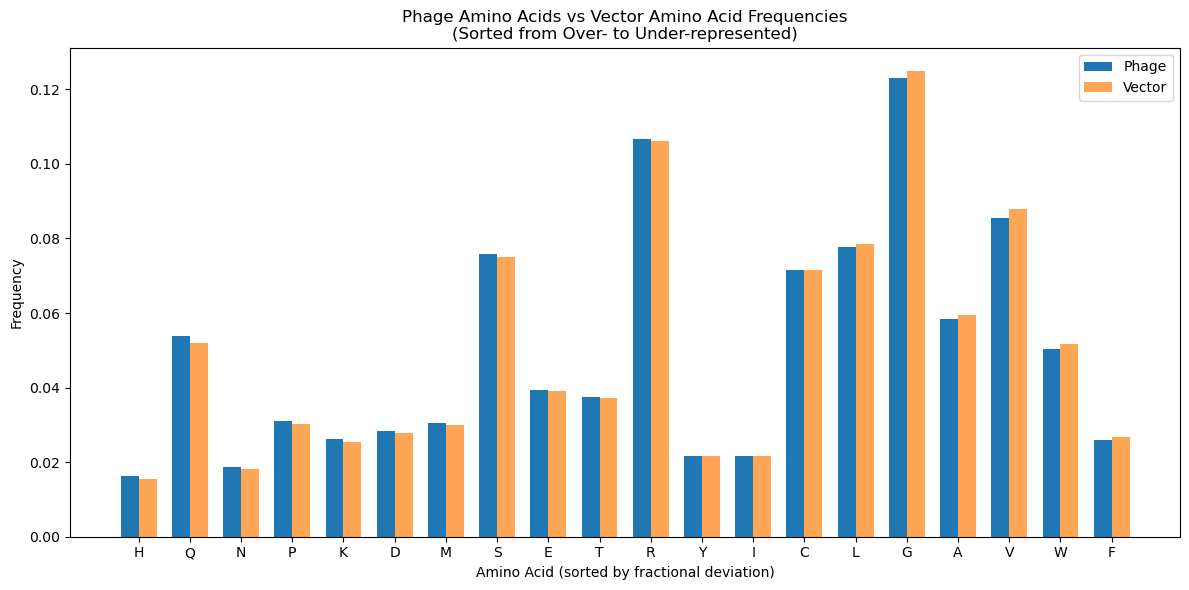

In [22]:
# Compute fractional deviation and sort
ztest_df['Fractional_Deviation'] = (ztest_df['ObservedFreq'] - ztest_df['ExpectedFreq']) / ztest_df['ExpectedFreq']
sorted_df = ztest_df.sort_values(by='Fractional_Deviation', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
x = np.arange(len(sorted_df))
width = 0.35

# Plotting frequencies (0–1 scale)
plt.bar(x - width/2, sorted_df['ObservedFreq'], width, label='Phage')
plt.bar(x + width/2, sorted_df['ExpectedFreq'], width, label='Vector', alpha=0.7)

plt.xticks(x, sorted_df['AminoAcid'])
plt.xlabel("Amino Acid (sorted by fractional deviation)")
plt.ylabel("Frequency")
plt.title("Phage Amino Acids vs Vector Amino Acid Frequencies\n(Sorted from Over- to Under-represented)")
plt.legend()
plt.tight_layout()
plt.show()

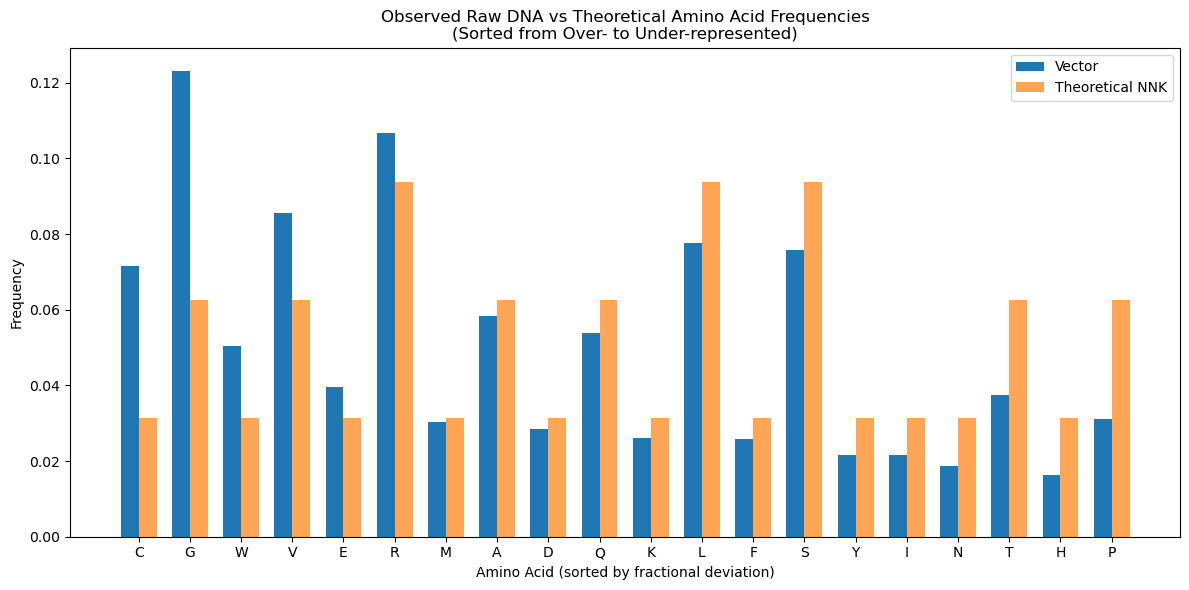

In [23]:
expected_freqs = {
    'A': 2/32, 'C': 1/32, 'D': 1/32, 'E': 1/32, 'F': 1/32,
    'G': 2/32, 'H': 1/32, 'I': 1/32, 'K': 1/32, 'L': 3/32,
    'M': 1/32, 'N': 1/32, 'P': 2/32, 'Q': 2/32, 'R': 3/32,
    'S': 3/32, 'T': 2/32, 'V': 2/32, 'W': 1/32, 'Y': 1/32
}

# Replace ExpectedFreq column using expected_freqs dictionary
ztest_df['ExpectedFreq'] = ztest_df['AminoAcid'].map(expected_freqs)

# Compute fractional deviation and sort
ztest_df['Fractional_Deviation'] = (
    (ztest_df['ObservedFreq'] - ztest_df['ExpectedFreq']) / ztest_df['ExpectedFreq']
)
sorted_df = ztest_df.sort_values(by='Fractional_Deviation', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
x = np.arange(len(sorted_df))
width = 0.35

# Plotting frequencies (0–1 scale)
plt.bar(x - width/2, sorted_df['ObservedFreq'], width, label='Vector')
plt.bar(x + width/2, sorted_df['ExpectedFreq'], width, label='Theoretical NNK', alpha=0.7)

plt.xticks(x, sorted_df['AminoAcid'])
plt.xlabel("Amino Acid (sorted by fractional deviation)")
plt.ylabel("Frequency")
plt.title("Observed Raw DNA vs Theoretical Amino Acid Frequencies\n(Sorted from Over- to Under-represented)")
plt.legend()
plt.tight_layout()
plt.show()

## Checking Number of Cysteines Per Peptide

In [24]:
file_path = r"/Volumes/Extreme SSD/NGS7/00_fastq/10m/NGS7_number_C.csv"
dfC = pd.read_csv(r"/Volumes/Extreme SSD/NGS7/00_fastq/10m/NGS7_number_C.csv")
dfC.head()

,GCTCTGGGTCGTGCTGGGGAGTTTTGTGAGCTTCAGCGGACTCTGTGC,9,ALGRAGEFCELQRTLC,4.51258E-06,0.000335599,2
0,GCTGGGCATCCGGGTAGTTATATTGAGGAGGTGGATAGGGGGAAGTGC,7,AGHPGSYIEEVDRGKC,0.000004,0.000336,1
1,GCTCTTGGGGAGGGTGGTATGGTGTATGGTGTGGGGGCTAGGTTGTGC,7,ALGEGGMVYGVGARLC,0.000004,0.000336,1
2,GCTCGTGTGGTGCATAGTGAGGGTAGGGCGCTGGGGGGGGTGGATTGC,7,ARVVHSEGRALGGVDC,0.000004,0.000336,1
3,GCTAAGGGGCGTGCTGTTAGGAGGAATCCTGAGTTTGGTAGGGGTTGC,7,AKGRAVRRNPEFGRGC,0.000004,0.000336,1
4,GCTAGGTCGTGTCCTCTGGCTTGGGATTAGTCTGTTTAGGTGGGGTGC,7,ARSCPLAWDQSVQVGC,0.000004,0.000336,2


In [25]:
from scipy.stats import binom
import pandas as pd

n = 14          # number of *random* positions
p = 1 / 32      # probability of cysteine at each position
total_peptides = 122598

# Distribution for additional cysteines (0 to 14), shift by +1 for guaranteed initial cysteine
x = list(range(n + 1))  # 0–14 additional cysteines → total cysteines 1–15
probs = binom.pmf(x, n, p)

# Adjust x to reflect total cysteine counts (1 to 15)
total_cysteines = [i + 1 for i in x]

# Put into DataFrame
df = pd.DataFrame({
    'Total Cysteines per Peptide': total_cysteines,
    'Probability': probs,
    'Expected Count (per 122598 peptides)': (probs * total_peptides).round(2)
})

print(df)

    Total Cysteines per Peptide   Probability  \
0                             1  6.411565e-01   
1                             2  2.895545e-01   
2                             3  6.071305e-02   
3                             4  7.833941e-03   
4                             5  6.949464e-04   
5                             6  4.483525e-05   
6                             7  2.169448e-06   
7                             8  7.997964e-08   
8                             9  2.257490e-09   
9                            10  4.854817e-11   
10                           11  7.830350e-13   
11                           12  9.185161e-15   
12                           13  7.407388e-17   
13                           14  3.676123e-19   
14                           15  8.470329e-22   

    Expected Count (per 122598 peptides)  
0                               78604.50  
1                               35498.81  
2                                7443.30  
3                                 960.43  


In [34]:
from scipy.stats import chisquare, binom

# Assume: last column in dfC contains the total number of cysteines per peptide (1 to 15)
observed_C = dfC[dfC.columns[-1]]

# Define theoretical distribution (binomial) for additional cysteines beyond the guaranteed first
n = 14         # number of variable positions
p = 1 / 32     # chance of cysteine per position

# Theoretical probabilities for 0–14 additional cysteines (i.e., total cysteines = 1–15)
probs = binom.pmf(range(n + 1), n, p)  # still 15 entries
total_peptides = len(observed_C)
expected_C = probs * total_peptides

# Observed counts for total cysteines per peptide: values from 1 to 15
observed_counts = observed_C.value_counts().reindex(range(1, 16), fill_value=0).sort_index()

# Normalize expected counts to exactly match total observed count
expected_C = expected_C * (observed_counts.sum() / expected_C.sum())

# Run chi-square test
chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_C)

# Report
print("Chi-square test results:")
print(f"Chi2 statistic = {chi2_stat:.2f}")
print(f"P-value = {p_value:.4f}")

# Optional: results table
results_df = pd.DataFrame({
    'Total Cysteines per Peptide': range(1, 16),
    'Observed Count': observed_counts.values,
    'Expected Count': expected_C.round(2)
})
print("\nObserved vs Expected:")
print(results_df)

Chi-square test results:
Chi2 statistic = 1660.88
P-value = 0.0000

Observed vs Expected:
    Total Cysteines per Peptide  Observed Count  Expected Count
0                             1           73015        78771.20
1                             2           38555        35574.09
2                             3            9621         7459.08
3                             4            1501          962.46
4                             5             155           85.38
5                             6              11            5.51
6                             7               0            0.27
7                             8               0            0.01
8                             9               0            0.00
9                            10               0            0.00
10                           11               0            0.00
11                           12               0            0.00
12                           13               0            0.00
13            

In [35]:
# Ensure observed and expected are aligned and numpy arrays
observed_array = observed_counts.values
expected_array = expected_C

# Calculate per-category z-scores
z_scores = (observed_array - expected_array) / np.sqrt(expected_array)

# Two-tailed p-values
raw_p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Bonferroni correction
bonferroni_p_values = np.minimum(raw_p_values * len(observed_array), 1.0)
significant = bonferroni_p_values < 0.05

# Add to results table
results_df["Z-score"] = np.round(z_scores, 2)
results_df["Raw P-value"] = raw_p_values
results_df["Bonferroni P-value"] = bonferroni_p_values
results_df["Significant"] = significant

# Show updated results
print("\nObserved vs Expected with Significance:")
print(results_df)


Observed vs Expected with Significance:
    Total Cysteines per Peptide  Observed Count  Expected Count  Z-score  \
0                             1           73015        78771.20   -20.51   
1                             2           38555        35574.09    15.80   
2                             3            9621         7459.08    25.03   
3                             4            1501          962.46    17.36   
4                             5             155           85.38     7.53   
5                             6              11            5.51     2.34   
6                             7               0            0.27    -0.52   
7                             8               0            0.01    -0.10   
8                             9               0            0.00    -0.02   
9                            10               0            0.00    -0.00   
10                           11               0            0.00    -0.00   
11                           12               0

In [29]:
file_path = r"/Volumes/Extreme SSD/NGS8/30-1181097629/00_fastq/15m/6cwhole_C_count.csv"
df6cwhole = pd.read_csv(file_path)
#dfC = dfC.dropna(subset=[df3.columns[-1]])
df6cwhole.head()

,GCTTTGTATCAGTTGGAGAATGGTGTTTTGGGTGGTCAGGTGTGTTGC,9,ALYQLENGVLGGQVCC,3.89E-06,0.000278439,2
0,GCTTGTGGGTCGGGGACTGTGGTTGGTAATATTGTGCATGTGTGTTGC,8,ACGSGTVVGNIVHVCC,0.000003,0.000278,3
1,GCTCTGTGGGCTGCGATGTATTTGGGGATTGTTGCTAGTGAGCGGTGC,8,ALWAAMYLGIVASERC,0.000003,0.000278,1
2,GCTACGCAGGTTGAGGAGTGTCCGGCGAGTATGGGGGGGTGTACGTGC,8,ATQVEECPASMGGCTC,0.000003,0.000278,3
3,GCTAGTTCGAAGCAGCCGGAGTTTTGTTATTGTAGGCCTATGCTGTGC,8,ASSKQPEFCYCRPMLC,0.000003,0.000278,3
4,GCTGGGATTCGGTGGGGTAGGGCGTGGAGGTGTACGTATCTGGTGTGC,8,AGIRWGRAWRCTYLVC,0.000003,0.000278,2


In [30]:
from scipy.stats import binom

n = 14          # number of *random* positions
p = 1 / 32      # probability of cysteine at each position
total_peptides = 345796

# Distribution for additional cysteines (0 to 14), shift by +1 for guaranteed initial cysteine
x = list(range(n + 1))  # 0–14 additional cysteines → total cysteines 1–15
probs = binom.pmf(x, n, p)

# Adjust x to reflect total cysteine counts (1 to 15)
total_cysteines = [i + 1 for i in x]

# Put into DataFrame
df = pd.DataFrame({
    'Total Cysteines per Peptide': total_cysteines,
    'Probability': probs,
    'Expected Count (per 122598 peptides)': (probs * total_peptides).round(2)
})

print(df)

    Total Cysteines per Peptide   Probability  \
0                             1  6.411565e-01   
1                             2  2.895545e-01   
2                             3  6.071305e-02   
3                             4  7.833941e-03   
4                             5  6.949464e-04   
5                             6  4.483525e-05   
6                             7  2.169448e-06   
7                             8  7.997964e-08   
8                             9  2.257490e-09   
9                            10  4.854817e-11   
10                           11  7.830350e-13   
11                           12  9.185161e-15   
12                           13  7.407388e-17   
13                           14  3.676123e-19   
14                           15  8.470329e-22   

    Expected Count (per 122598 peptides)  
0                              221709.34  
1                              100126.80  
2                               20994.33  
3                                2708.95  


In [31]:
from scipy.stats import chisquare, binom

# Assume: last column in dfC contains the total number of cysteines per peptide (1 to 15)
observed_C = df6cwhole[df6cwhole.columns[-1]]

# Define theoretical distribution (binomial) for additional cysteines beyond the guaranteed first
n = 14         # number of variable positions
p = 1 / 32     # chance of cysteine per position

# Theoretical probabilities for 0–14 additional cysteines (i.e., total cysteines = 1–15)
probs = binom.pmf(range(n + 1), n, p)  # still 15 entries
total_peptides = len(observed_C)
expected_C = probs * total_peptides

# Observed counts for total cysteines per peptide: values from 1 to 15
observed_counts = observed_C.value_counts().reindex(range(1, 16), fill_value=0).sort_index()

# Normalize expected counts to exactly match total observed count
expected_C = expected_C * (observed_counts.sum() / expected_C.sum())

# Run chi-square test
chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_C)

# Report
print("Chi-square test results:")
print(f"Chi2 statistic = {chi2_stat:.2f}")
print(f"P-value = {p_value:.4f}")

# Optional: results table
results_df = pd.DataFrame({
    'Total Cysteines per Peptide': range(1, 16),
    'Observed Count': observed_counts.values,
    'Expected Count': expected_C.round(2)
})
print("\nObserved vs Expected:")
print(results_df)

Chi-square test results:
Chi2 statistic = 4630.04
P-value = 0.0000

Observed vs Expected:
    Total Cysteines per Peptide  Observed Count  Expected Count
0                             1          205327       221602.26
1                             2          108826       100078.44
2                             3           26764        20984.19
3                             4            4204         2707.64
4                             5             470          240.19
5                             6              35           15.50
6                             7               3            0.75
7                             8               0            0.03
8                             9               0            0.00
9                            10               0            0.00
10                           11               0            0.00
11                           12               0            0.00
12                           13               0            0.00
13            

In [33]:
# Ensure observed and expected are aligned and numpy arrays
observed_array = observed_counts.values
expected_array = expected_C

# Calculate per-category z-scores
z_scores = (observed_array - expected_array) / np.sqrt(expected_array)

# Two-tailed p-values
raw_p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Bonferroni correction
bonferroni_p_values = np.minimum(raw_p_values * len(observed_array), 1.0)
significant = bonferroni_p_values < 0.05

# Add to results table
results_df["Z-score"] = np.round(z_scores, 2)
results_df["Raw P-value"] = raw_p_values
results_df["Bonferroni P-value"] = bonferroni_p_values
results_df["Significant"] = significant

# Show updated results
print("\nObserved vs Expected with Significance:")
print(results_df)


Observed vs Expected with Significance:
    Total Cysteines per Peptide  Observed Count  Expected Count  Z-score  \
0                             1          205327       221602.26   -34.57   
1                             2          108826       100078.44    27.65   
2                             3           26764        20984.19    39.90   
3                             4            4204         2707.64    28.76   
4                             5             470          240.19    14.83   
5                             6              35           15.50     4.95   
6                             7               3            0.75     2.60   
7                             8               0            0.03    -0.17   
8                             9               0            0.00    -0.03   
9                            10               0            0.00    -0.00   
10                           11               0            0.00    -0.00   
11                           12               0

## Baseline Experimental Rankings